# Tutorial on mdPCA and maasMDS Visualization

In [1]:
import sys, os

dir = os.path.abspath('../')
if not dir in sys.path: sys.path.append(dir)

import logging
from snputils.snp.io.read.vcf import VCFReader
from snputils.ancestry.io.local.read import MSPReader
from snputils.processing.mdpca import mdPCA
from snputils.processing.maasmds import maasMDS
from snputils.processing._utils.gen_tools import logger_config
from snputils.visualization.scatter_plot import scatter

### 1. Load Input Data

Load data files required for running mdPCA and maasMDS, including SNP and LAI data, along with the labels file specifying ancestry labels.
* **SNP data** is loaded from a VCF file into a `SNPObject`. The parameter sum_strands=False ensures that haplotypes are not combined initially.
* **LAI data** is loaded from an MSP file into a `LocalAncestryObject`.

In [73]:
# File paths for SNP data, LAI data, and sample labels
vcf_path = '../data/easComp_6_samples_chr1.vcf'
msp_path = '../data/easComp_6_samples_chr1.msp'
labels_file = '../data/easComp_6_samples_chr1_labels.tsv'

# Load SNP data from VCF file
snpobj = VCFReader(vcf_path).read(sum_strands=False)

# Load LAI data from MSP file
laiobj = MSPReader(msp_path).read()

# Display the ancestry mapping
print("\nAncestry map:", laiobj.ancestry_map)

# Configure logging to display messages in the console
logging.config.dictConfig(logger_config(verbose=True))

[INFO] 2025-03-05 14:48:27: Reading ../data/easComp_6_samples_chr1.vcf
[INFO] 2025-03-05 14:48:28: Finished reading ../data/easComp_6_samples_chr1.vcf
[INFO] 2025-03-05 14:48:28: Reading '../data/easComp_6_samples_chr1.msp'...

Ancestry map: {'0': 'Africa', '1': 'Americas', '2': 'Europe', '3': 'SouthAsia', '4': 'EastAsia'}


### 2. Understanding the Labels File

The labels file is a TSV text file that contains essential metadata about each individual in your study. mdPCA and maasMDS use this file to align the genotype data (from snpobj) and local ancestry data (from laiobj) with population information. Below are key columns and how they are used:

* `indID`: Unique identifier for each individual; must match identifiers in `snpobj` and `laiobj`.
* `label`: Population or group label (e.g., "popA", "popB"). These labels help interpret how samples cluster on principal components (e.g., color-coding in PCA plots).
* `weight`: Numeric weight assigned to each individual. If an individual’s weight is 0, that individual is excluded from the analysis. If `is_weighted=False`, this column is ignored.
* `combination`: Assigns individuals into combined groups. This is especially useful when `group_snp_frequencies_only=True`: 
    * A combination value of 0 means no grouping; each individual is considered separately.
    * A non-zero value (e.g., 1, 2, 3) indicates that all individuals with the same combination number are grouped together.
* `combination_weight`: Weight assigned to each group if combination is non-zero. If not provided, defaults to 1.

All members of a group must share the same `label` and `combination_weight`.

### 3. Run mdPCA

Initialize and run the mdPCA analysis.

**Key Parameter Explanations**

* **snpobj**: SNPObject with SNP data loaded from the VCF file.
* **laiobj**: LocalAncestryObject with LAI data loaded from the MSP file.
* **labels_file**: Sample labels file, mapping individuals to population labels and optionally groups.
* **ancestry**: Ancestry for which dimensionality reduction is to be performed. Ancestry counter starts at `0`. The ancestry input can be:
    * An integer (e.g., 0, 1, 2, 3, 4).
    * A string representation of an integer (e.g., '0', '1', '2', '3', '4').
    * A string matching one of the ancestry map values (e.g., 'Africa', 'Americas', 'Europe', 'SouthAsia', 'EastAsia').
* **average_strands**: True if the haplotypes from the two parents are to be combined (averaged) for each individual, or False otherwise.
* **force_nan_incomplete_strands**: If True, sets the result to NaN if either haplotype in a pair is NaN. Otherwise, computes the mean while ignoring NaNs (e.g., 0|NaN -> 0, 1|NaN -> 1).
* **is_weighted**: If True, assigns individual weights from the `weight` column in `labels_file`. Otherwise, all individuals have equal weight of `1`.
* **min_percent_snps**: Minimum percentage of SNPs that must be known for an individual and of the ancesstry of interet to be included in the analysis. All individuals with fewer percent of unmasked SNPs than this threshold will be excluded.
* **group_snp_frequencies_only**: If True, mdPCA is performed exclusively on group-level SNP frequencies, ignoring individual-level data. This applies when `is_weighted` is set to True and a `combination` column is provided in the `labels_file`,  meaning individuals are aggregated into groups based on their assigned labels. If False, mdPCA is performed on individual-level SNP data alone or on both individual-level and group-level SNP frequencies when `is_weighted` is True and a `combination` column is provided.
* **n_components**: The number of principal components.

In [64]:
# Initialize the mdPCA object with SNP and LAI data, labels file, and selected ancestry
mdpca = mdPCA(
    method='weighted_cov_pca',         # Weighted covariance PCA (default)
    snpobj=snpobj,                     # SNP genotype data from VCF
    laiobj=laiobj,                     # Local ancestry data from MSP
    labels_file=labels_file,           # Sample metadata file (.tsv) with population labels and optional weights
    ancestry='EastAsia',               # Ancestry of interest (string or integer index)
    average_strands=False,             # Keep haplotypes separate instead of averaging parental strands
    force_nan_incomplete_strands=False,# If True, averaged strands with one missing haplotype are set to NaN
    is_weighted=False,                 # If True, applies weights from the 'weight' column in labels_file
    min_percent_snps=4,                # Minimum SNP coverage threshold from ancestry of interest for individual inclusion
    group_snp_frequencies_only=False,  # If True, analyzes only group-level SNP frequencies (excludes individual sequences)
    n_components=2                     # Number of principal components to compute
)

[INFO] 2025-03-05 14:46:57: ------ Array Processing: ------
[INFO] 2025-03-05 14:46:57: SNPObject Processing Time: --- 0.13059544563293457 seconds ---
[DEBUG] 2025-03-05 14:46:57: Number of SNPs within window ranges for chromosome 1: 64073
[INFO] 2025-03-05 14:46:57: TSV Processing Time: --- 0.016486406326293945 seconds ---
[INFO] 2025-03-05 14:46:57: Masking for ancestry 4 --- 0.0012 seconds
[INFO] 2025-03-05 14:46:57: Covariance Matrix --- 0.16022467613220215 seconds ---
[INFO] 2025-03-05 14:46:57: Percent variance explained by the principal component 1: 40.669909765458044
[INFO] 2025-03-05 14:46:57: Percent variance explained by the principal component 2: 35.323312747684334


We can now inspect the output attributes:

In [67]:
print("X_new_ shape:", mdpca.X_new_)
print("\nhaplotypes:", mdpca.haplotypes_)
print("samples_:", mdpca.samples_ if hasattr(mdpca, "samples_") else "Not available")
print("Total variants:", len(mdpca.variants_id_))
print("variants_id_ (first few):", mdpca.variants_id_[:5])

X_new_ shape: [[ 0.05753786 -0.07705574]
 [ 0.31123924  0.07635565]
 [-0.14243854 -0.03442202]
 [-0.07117519 -0.22365777]
 [-0.15516337  0.25877988]]

haplotypes: ['GA000856_GA000856_A', 'GA000856_GA000856_B', 'GA000857_GA000857_A', 'GA000858_GA000858_A', 'GA000858_GA000858_B']
samples_: ['GA000856_GA000856', 'GA000856_GA000856', 'GA000857_GA000857', 'GA000858_GA000858', 'GA000858_GA000858']
Total variants: 64073
variants_id_ (first few): [1.435428, 1.678428, 1.555838, 1.566838, 1.564648]


And plot the PCA results:

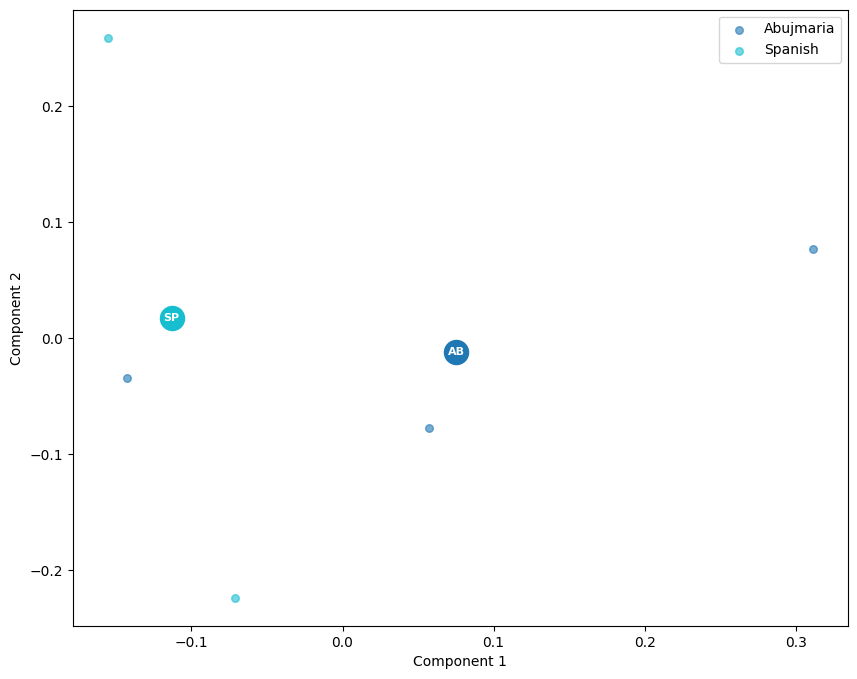

In [68]:
scatter(mdpca, labels_file)

### 3. Run maasMDS

Initialize and run the maasMDS analysis.

In [70]:
# Configure logging to display messages in the console
logging.config.dictConfig(logger_config(verbose=True))

# Initialize the maasMDS object with SNP and LAI data, labels file, and selected ancestry
maasmds = maasMDS(
    snpobj=snpobj,                     # SNP genotype data from VCF
    laiobj=laiobj,                     # Local ancestry data from MSP
    labels_file=labels_file,           # Sample metadata file (.tsv) with population labels and optional weights
    ancestry='EastAsia',               # Ancestry of interest (string or integer index)
    average_strands=False,             # Keep haplotypes separate instead of averaging parental strands
    force_nan_incomplete_strands=False,# If True, averaged strands with one missing haplotype are set to NaN
    is_weighted=False,                 # If True, applies weights from the 'weight' column in labels_file
    min_percent_snps=4,                # Minimum SNP coverage threshold from ancestry of interest for individual inclusion
    group_snp_frequencies_only=False,  # If True, analyzes only group-level SNP frequencies (excludes individual sequences)
    n_components=2                     # Number of principal components to compute
)

[INFO] 2025-03-05 14:47:50: ------ Array Processing: ------
[INFO] 2025-03-05 14:47:50: SNPObject Processing Time: --- 0.13159394264221191 seconds ---
[DEBUG] 2025-03-05 14:47:50: Number of SNPs within window ranges for chromosome 1: 64073
[INFO] 2025-03-05 14:47:50: TSV Processing Time: --- 0.014508962631225586 seconds ---
[INFO] 2025-03-05 14:47:50: Masking for ancestry 4 --- 0.0014 seconds
[INFO] 2025-03-05 14:47:50: Distance Matrix building: --- 0.008743047714233398 seconds ---


We can now inspect the output attributes:

In [71]:
print("X_new_ shape:", maasmds.X_new_)
print("\nhaplotypes:", maasmds.haplotypes_)
print("samples_:", maasmds.samples_ if hasattr(maasmds, "samples_") else "Not available")
print("Total variants:", len(maasmds.variants_id_))
print("variants_id_ (first few):", maasmds.variants_id_[:5])

X_new_ shape: [[-0.4475931  -0.02684126]
 [-0.53592473  0.33056938]
 [-0.00128624 -0.34214979]
 [ 0.37509062 -0.60215815]
 [ 0.60971344  0.64057983]]

haplotypes: ['GA000856_GA000856_A', 'GA000856_GA000856_B', 'GA000857_GA000857_A', 'GA000858_GA000858_A', 'GA000858_GA000858_B']
samples_: ['GA000856_GA000856', 'GA000856_GA000856', 'GA000857_GA000857', 'GA000858_GA000858', 'GA000858_GA000858']
Total variants: 64073
variants_id_ (first few): [1.435428, 1.678428, 1.555838, 1.566838, 1.564648]


And plot the PCA results:

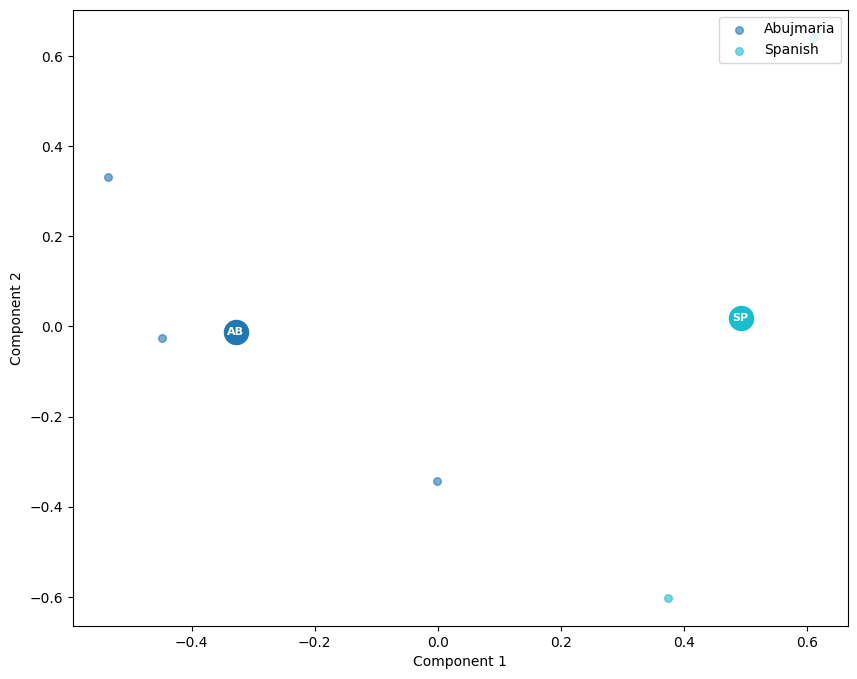

In [72]:
scatter(maasmds, labels_file)